In [1]:
!pip install -qq transformers
!pip install -qq datasets

     |████████████████████████████████| 3.5 MB 7.0 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 6.8 MB 51.7 MB/s 
     |████████████████████████████████| 895 kB 68.3 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 311 kB 8.1 MB/s 
     |████████████████████████████████| 133 kB 39.8 MB/s 
     |████████████████████████████████| 1.1 MB 15.1 MB/s 
     |████████████████████████████████| 243 kB 7.2 MB/s 
     |████████████████████████████████| 144 kB 49.2 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 39.9 MB/s 


In [2]:
import transformers
import datasets
from transformers import AutoTokenizer,AutoModelForQuestionAnswering, AutoModelForSequenceClassification,AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers import DataCollator, DataCollatorForLanguageModeling,default_data_collator
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import random
from textwrap import wrap
from datetime import datetime
from datasets import load_from_disk
from datasets import load_dataset
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE= 8.584684132528283e-05
WEIGHT_DECAY = 0.10919253165395515
WARMUP_STEPS = 50
RANDOM_SEED=32




QA_OUTPUT_PATH= "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }


def seq_model_init(modelname_or_path):
  temp_model =  AutoModelForSequenceClassification.from_pretrained(modelname_or_path,num_labels=3).to(device)
  return temp_model


def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)


In [5]:
set_seed(RANDOM_SEED)


In [9]:
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_task/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    weight_decay= WEIGHT_DECAY,               # strength of weight decay
    learning_rate= LEARNING_RATE, 
    warmup_steps = WARMUP_STEPS,
    logging_dir='./disbert_hate_task/logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  seq_model = seq_model_init(QA_OUTPUT_PATH)

  trainer = Trainer(
      model=seq_model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_task/models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)

Some weights of the model checkpoint at /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad were not used when initializing DistilBertForSequenceClassification: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.w

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.669700,0.540339,0.779352,0.727934,0.735986,0.721026,0.706436,0.679074,0.736096,0.860355,0.878193,0.843228,0.617010,0.605809,0.628633
2,0.493400,0.496043,0.797381,0.743964,0.763380,0.740435,0.756656,0.814889,0.706190,0.869989,0.891892,0.849136,0.605247,0.514523,0.734815
3,0.364700,0.540804,0.807255,0.766131,0.765314,0.769599,0.777936,0.822938,0.737601,0.873397,0.869678,0.877147,0.647059,0.616183,0.681193
4,0.251000,0.642853,0.804894,0.764948,0.761572,0.769597,0.784993,0.820926,0.752074,0.871124,0.863384,0.879005,0.638727,0.624481,0.653637


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/1/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/1/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/1/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/1/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.652800,0.552738,0.772913,0.706633,0.747951,0.687188,0.714583,0.690141,0.740821,0.851935,0.917068,0.795440,0.553380,0.454357,0.707593
2,0.494400,0.521265,0.795879,0.746498,0.757306,0.755060,0.748151,0.865191,0.659004,0.871354,0.862643,0.880242,0.619988,0.537344,0.732673
3,0.360500,0.535443,0.806182,0.768316,0.764642,0.772283,0.788566,0.804829,0.772947,0.871354,0.862643,0.880242,0.645028,0.649378,0.640737
4,0.242500,0.622315,0.809187,0.768819,0.764425,0.775001,0.794090,0.838028,0.754529,0.876148,0.865605,0.886950,0.636219,0.621369,0.651795


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/2/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/2/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/2/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/2/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.655700,0.550199,0.773771,0.715833,0.735566,0.705708,0.698318,0.710262,0.686770,0.854649,0.888190,0.823550,0.594530,0.518672,0.696379
2,0.480700,0.519811,0.794806,0.734991,0.764251,0.728280,0.768501,0.814889,0.727110,0.867945,0.905220,0.833617,0.568528,0.464730,0.732026
3,0.351700,0.549562,0.807040,0.766435,0.766717,0.766360,0.792640,0.801811,0.783677,0.873083,0.874861,0.871313,0.633580,0.622407,0.645161
4,0.231100,0.666835,0.804464,0.766715,0.761318,0.772748,0.792176,0.814889,0.770695,0.870628,0.857090,0.884601,0.637340,0.646266,0.628658


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/3/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/3/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/3/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/3/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.660900,0.552437,0.773342,0.706868,0.756376,0.689527,0.723618,0.724346,0.722892,0.849131,0.913736,0.793059,0.547855,0.430498,0.753176
2,0.480200,0.516062,0.795235,0.754446,0.753198,0.763202,0.776011,0.859155,0.707539,0.859396,0.847464,0.871668,0.627933,0.582988,0.680387
3,0.346400,0.526239,0.809187,0.764836,0.769958,0.765706,0.804924,0.855131,0.760286,0.872707,0.880785,0.864776,0.616876,0.561203,0.684810
4,0.234700,0.667931,0.805108,0.765341,0.763014,0.768494,0.804475,0.831992,0.778719,0.869468,0.865605,0.873366,0.622081,0.607884,0.636957


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/4/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/4/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/4/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/4/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.651100,0.545049,0.776991,0.719815,0.744356,0.707295,0.708229,0.714286,0.702275,0.854111,0.894113,0.817536,0.597105,0.513485,0.713256
2,0.477900,0.492314,0.798669,0.757496,0.752923,0.763610,0.755131,0.795775,0.718438,0.869647,0.857090,0.882577,0.647709,0.637967,0.657754
3,0.350600,0.523007,0.814552,0.776192,0.770871,0.782436,0.794004,0.825956,0.764432,0.880706,0.867827,0.893974,0.653866,0.653527,0.654206
4,0.224800,0.644025,0.807469,0.764613,0.762699,0.767711,0.792453,0.823944,0.763281,0.876789,0.873380,0.880224,0.624599,0.605809,0.644592


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/5/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/5/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/5/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/5/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.658400,0.543349,0.782786,0.734582,0.739579,0.733676,0.726925,0.764588,0.692799,0.857720,0.864865,0.850692,0.619101,0.571577,0.675245
2,0.483900,0.510265,0.795664,0.753122,0.750752,0.760013,0.761242,0.825956,0.705933,0.865392,0.854498,0.876567,0.632731,0.599585,0.669757
3,0.357400,0.549946,0.808328,0.763730,0.771388,0.763093,0.796209,0.845070,0.752688,0.871711,0.883006,0.860700,0.623272,0.561203,0.700777
4,0.236200,0.656167,0.801030,0.761986,0.757712,0.766920,0.794747,0.821932,0.769303,0.866929,0.857460,0.876609,0.624283,0.621369,0.627225


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/6/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/6/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/6/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/6/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.658700,0.538534,0.786220,0.735913,0.745305,0.732496,0.734262,0.768612,0.702852,0.860833,0.875972,0.846209,0.612644,0.552905,0.686856
2,0.474100,0.494381,0.805323,0.752635,0.783322,0.743031,0.771142,0.811871,0.734304,0.871959,0.908923,0.837884,0.614806,0.508299,0.777778
3,0.344000,0.554329,0.808328,0.764424,0.766410,0.767572,0.785547,0.842052,0.736148,0.875440,0.875602,0.875278,0.632287,0.585062,0.687805
4,0.209400,0.660640,0.808972,0.768862,0.766302,0.772216,0.788144,0.815895,0.762218,0.875396,0.870048,0.880810,0.643046,0.630705,0.655879


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/7/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/7/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/7/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/7/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.654600,0.555022,0.784288,0.735363,0.740940,0.734446,0.734129,0.773642,0.698456,0.859186,0.867456,0.851072,0.612776,0.562241,0.673292
2,0.476900,0.513554,0.794806,0.753464,0.758568,0.749191,0.756136,0.728370,0.786102,0.863270,0.871899,0.854809,0.640986,0.647303,0.634791
3,0.339100,0.566037,0.807040,0.762140,0.767684,0.762002,0.791052,0.836016,0.750678,0.872641,0.881525,0.863933,0.622727,0.568465,0.688442
4,0.221100,0.689058,0.808972,0.771492,0.768270,0.774937,0.796443,0.810865,0.782524,0.873040,0.865605,0.880603,0.644995,0.648340,0.641684


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/8/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/8/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/8/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/8/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.644000,0.552100,0.766259,0.715114,0.727958,0.705173,0.682801,0.667002,0.699367,0.842539,0.869678,0.817043,0.620000,0.578838,0.667464
2,0.467600,0.502205,0.798025,0.750132,0.761325,0.750158,0.771375,0.835010,0.716753,0.865546,0.877083,0.854309,0.613475,0.538382,0.712912
3,0.331800,0.566286,0.804679,0.765938,0.764516,0.767524,0.803368,0.815895,0.791220,0.868597,0.866346,0.870860,0.625850,0.620332,0.631468
4,0.212800,0.690503,0.802962,0.766851,0.762247,0.771884,0.799605,0.814889,0.784884,0.866204,0.854498,0.878234,0.634743,0.646266,0.623624


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/9/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/9/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/9/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/9/checkpoint-1166
Configuration saved in /content/drive/MyDrive/D

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file /content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Dissertation/disbert_hate_ml/results/best_model_squad",
  "activation": "gelu",
  "architectures": [
    "DistilBertForQuestionAnswering"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.659400,0.541565,0.779566,0.720245,0.740460,0.710822,0.714848,0.731388,0.699038,0.860755,0.894854,0.829160,0.585132,0.506224,0.693182
2,0.481800,0.503446,0.794806,0.751064,0.753163,0.749503,0.753105,0.762575,0.743867,0.865183,0.870789,0.859649,0.634904,0.615145,0.655973
3,0.357200,0.561501,0.795235,0.750122,0.749454,0.755256,0.773259,0.831992,0.722271,0.865811,0.861163,0.870509,0.611296,0.572614,0.655582
4,0.239500,0.649979,0.804464,0.763620,0.764819,0.763006,0.797625,0.810865,0.784810,0.869037,0.873380,0.864736,0.624197,0.604772,0.644912


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/10/checkpoint-583
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/10/checkpoint-583/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_task/results/10/checkpoint-583/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_task/results/10/checkpoint-1166
Configuration saved in /content/drive/MyDri

In [10]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_task.csv')

In [11]:
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
4,0.529357,0.785316,0.742649,0.737345,0.749163,0.754445,0.790534,0.721507,0.85924,0.845556,0.873374,0.614263,0.611399,0.617155,3.1729,1468.063,23.007,4.0,5


In [12]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
3,0.506378,0.805496,0.764829,0.764612,0.773048,0.766652,0.851964,0.69687,0.871968,0.858889,0.885452,0.655866,0.60829,0.711515,3.1773,1466.031,22.976,4.0,4


In [13]:
#Print median f1
results_df["eval_f1"].median()

0.7456612144989003

In [14]:
#Print average values
results_df.mean()

eval_loss                      0.510480
eval_accuracy                  0.796780
eval_f1                        0.748721
eval_precision                 0.759284
eval_recall                    0.749382
eval_hate_f1                   0.761477
eval_hate_recall               0.813797
eval_hate_precision            0.717901
eval_offensive_f1              0.867881
eval_offensive_recall          0.875593
eval_offensive_precision       0.861053
eval_normal_f1                 0.616806
eval_normal_recall             0.558756
eval_normal_precision          0.698897
eval_runtime                   3.173450
eval_samples_per_second     1467.947100
eval_steps_per_second         23.005600
epoch                          4.000000
model_run                      5.500000
dtype: float64

In [15]:
results_df.std()

eval_loss                    0.011077
eval_accuracy                0.006815
eval_f1                      0.007371
eval_precision               0.013542
eval_recall                  0.011175
eval_hate_f1                 0.007950
eval_hate_recall             0.038525
eval_hate_precision          0.032722
eval_offensive_f1            0.006199
eval_offensive_recall        0.023427
eval_offensive_precision     0.016646
eval_normal_f1               0.019583
eval_normal_recall           0.055521
eval_normal_precision        0.055624
eval_runtime                 0.033442
eval_samples_per_second     15.209067
eval_steps_per_second        0.238198
epoch                        0.000000
model_run                    3.027650
dtype: float64

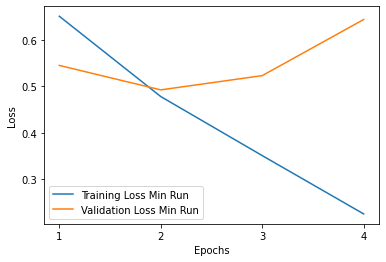

In [3]:
#Data below manually copied from 4 (Max) and 5th (Min) runs
training_loss_min = [0.6511,0.477900,0.350600,0.224800]
training_loss_max = [0.660900,0.4802,0.3464,0.23470]
val_loss_min = [0.545049,0.492314,0.523007,0.644025]
val_loss_max = [0.552437,0.516062,0.526239,0.667931]
epoch_list=[1,2,3,4]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()

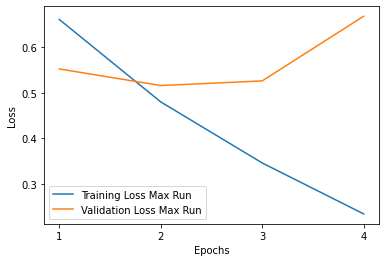

In [4]:
plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()